This notebook takes an image/text pair and runs our algorithms on them find the ideal landing point

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import gc
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
import copy
import torch
import torch.nn as nn
from torchvision import transforms as T
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!pip install -q segmentation-models-pytorch
!pip install ftfy==5.9
!pip install omegaconf==2.0.5
import segmentation_models_pytorch as smp

# Clip Imports
os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
from utils.simple_tokenizer import SimpleTokenizer
from omegaconf import OmegaConf
from model.model import CLIP
from utils import load_config_file

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.chdir('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Image/Text


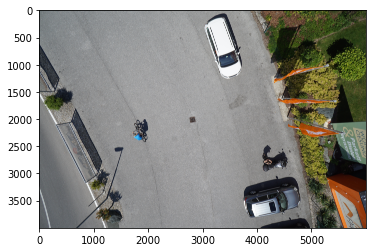

In [3]:
img_number = "596"
img_root = '/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Zero_Shot_Car/'
img_path = img_root + img_number + ".jpg"
img = Image.open(img_path)
plt.imshow(img)

In [4]:
os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
tokenizer = SimpleTokenizer()
def tokenize(text):
    sot_token = tokenizer.encoder["<|startoftext|>"]
    eot_token = tokenizer.encoder["<|endoftext|>"]
    tokens = [sot_token] + tokenizer.encode(text) + [eot_token]
    result = torch.zeros(77, dtype=torch.long)
    result[:len(tokens)] = torch.tensor(tokens)
    return result

text_com = "Red cross near a car"
print(text_com)

token_com = tokenize(text_com)
print(token_com)
os.chdir('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/')

Red cross near a car
tensor([49406,   736,  3417,  2252,   320,  1615, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


# CLIP Pipe

Use location grid to create images with red crosses to be fed to clip

In [5]:
def draw_red_cross(img, x, y, size=200):
  w,h = int(size/2),int(size/8)
  W,H = img.shape[0],img.shape[1]
  im = copy.deepcopy(img)
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),0] = 255
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),1] = 0
  im[max(0,x-w):min(W,x+w),max(0,y-h):min(H,y+h),2] = 0
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),0] = 255
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),1] = 0
  im[max(0,x-h):min(W,x+h),max(0,y-w):min(H,y+w),2] = 0
  return im


In [6]:
size = 200
img_grid = []

img = np.array(img)

red_cross_map = copy.deepcopy(img)

for x in np.linspace(size,img.shape[0]-size,10):
  img_row = []
  for y in np.linspace(size,img.shape[1]-size,11):
    red_cross_map = draw_red_cross(red_cross_map,int(x),int(y))
    img_row.append(draw_red_cross(img,int(x),int(y)))
  img_grid.append(img_row)

In [7]:
# plt.imshow(red_cross_map)

Crop red cross images to work for clip (1400,1200) No padding

In [8]:
crop_grid = []

i = 0
for x in np.linspace(size,img.shape[0]-size,10):
  j = 0
  crop_row = []
  for y in np.linspace(size,img.shape[1]-size,11):

    x_min = x - 700
    if x_min < 0:
      x_min = 0

    x_max = x + 700
    if x_max > 4000:
      x_max = 4000

    y_min = y - 600
    if y_min < 0:
      y_min = 0

    y_max = y + 600
    if y_max > 6000:
      y_max = 6000

    crop_row.append(img_grid[i][j][int(x_min):int(x_max),int(y_min):int(y_max),:])
    j += 1
  crop_grid.append(crop_row)
  i += 1

del img_grid

In [9]:
# plt.imshow(crop_grid[6][4])

Query CLIP

In [10]:
def _transform(n_px):
    return T.Compose([
        T.Resize(n_px, interpolation=Image.BICUBIC),
        T.CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize((0.4225, 0.4012, 0.3659), (0.2681, 0.2635, 0.2763)), # COCO mean, std
    ])

def query_clip(text,img_grid):
  with torch.no_grad():
    os.chdir('/content/drive/MyDrive/DL-project/clip-training/')
    MODEL_CONFIG_PATH = 'model/model_config.yaml'

    model_config = load_config_file(MODEL_CONFIG_PATH)

    model_params = dict(model_config.RN50)
    model_params['vision_layers'] = tuple(model_params['vision_layers'])
    model_params['vision_patch_size'] = None
    model = CLIP(**model_params)
    if torch.cuda.is_available():
      checkpoint = torch.load('/content/drive/MyDrive/DL-project/clip-training/saved_checkpoints/trained_checkpoint.pt')
    else:
      checkpoint = torch.load('/content/drive/MyDrive/DL-project/clip-training/saved_checkpoints/trained_checkpoint.pt', map_location=torch.device('cpu'))
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
      model = model.to(torch.device(0))
    model.eval()

    scores = np.zeros((10,11))

    for x in range(10):
      for y in range(11):
        img = Image.fromarray(img_grid[x][y])
        img = _transform(224)(img)
        if torch.cuda.is_available():
          image_features, text_features = model(img.unsqueeze(0).cuda(), text.unsqueeze(0).cuda())
        else:
          image_features, text_features = model(img.unsqueeze(0), text.unsqueeze(0))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        cos_sim = torch.nn.CosineSimilarity(dim=0)
        output = cos_sim(image_features[0], text_features[0])
        scores[x,y] = output.item()

  del model
  del state_dict
  del checkpoint
  del model_params
  del model_config
  del img
  del image_features
  del text_features
  del cos_sim
  del output
  gc.collect()
  # torch.cuda.empty_cache()

  return scores

scores = query_clip(token_com,crop_grid)

del crop_grid
del crop_row
del red_cross_map
del token_com

gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Rank grid locations

In [11]:
def topk(scores, k, axis=None):

    input = -1*scores
    ind = np.argpartition(input, k, axis=axis)
    ind = np.take(ind, np.arange(k), axis=axis) # k non-sorted indices
    input = np.take_along_axis(input, ind, axis=axis) # k non-sorted values

    # sort within k elements
    ind_part = np.argsort(input, axis=axis)
    ind = np.take_along_axis(ind, ind_part, axis=axis)
    input *= -1
    val = np.take_along_axis(input, ind_part, axis=axis) 
    return ind, val

ind,val = topk(scores,3)

max_ind = []
for index in ind:
  max_ind.append(np.unravel_index(index, scores.shape))

print("Max Indexes")
print(max_ind)
print("Max Scores")
print(val)

Max Indexes
[(1, 6), (3, 1), (0, 6)]
Max Scores
[0.55413675 0.53087389 0.52032542]


Display top k choices

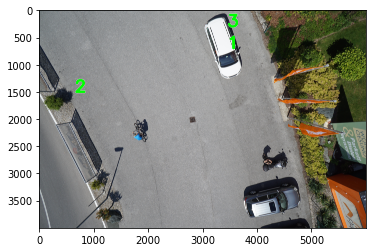

In [12]:
temp = Image.fromarray(img)
temp = temp.convert("RGBA")
top_k_map = np.array(temp)

top_k_map[:,:] = [255,255,255,0]

top_k_circ = copy.deepcopy(top_k_map)

x = np.linspace(size,img.shape[0]-size,10)
y = np.linspace(size,img.shape[1]-size,11)

for i in range(len(val)):
  xind = max_ind[i][0]
  yind = max_ind[i][1]
  cv2.circle(top_k_circ,(int(y[yind]),int(x[xind])), 75, (140,255,0,255), -1)
  cv2.putText(top_k_map,str(i+1),(int(y[yind]-100),int(x[xind]+100)),cv2.FONT_HERSHEY_SIMPLEX,10,(0,255,0,255),50,cv2.LINE_AA)

plt.imshow(img)
plt.imshow(top_k_map)


plt.savefig('/content/drive/MyDrive/DL-project/DL_Full_Pipeline/Zero_Shot_Car/Zero_Shot_Untrained_Ranked/' + img_number + ".png")

In [13]:
# xind = max_ind[0][0]
# yind = max_ind[0][1]

# plt.imshow(crop_grid[xind][yind])